**DATA CLEANING AND DATA ANALYSIS NOTEBOOK**

**ABSTRACT**

Following information for Yelp is analyzed in this jupyter notebook:

1) Business: Contains business data like location and categories

2) Reviews: Contains review text data like the user_id that wrote the review and the business_id the review is written for

3) User: Contains user data including the user's friend mapping

4) Tips: Contains tips written by a user on a business

use-cases from these datasets are also visualized in this notebook **using seaborn and matplotlib**


In [0]:
#imports 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import  GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_id = '1q8cR7hj3xuZaVdKJUD2LOE-r5VI6YBk8'
downloaded = drive.CreateFile({'id':file_id})
#print('Downloaded content"{}"'.format(downloaded.GetContentString()))
downloaded.GetContentFile('YelpDataset.zip')


In [0]:
ls

adc.json  sample_data/  YelpDataset.zip


In [0]:
%%time
import zipfile
with zipfile.ZipFile("YelpDataset.zip","r") as zip_ref:
  print('extracting zip file')
  zip_ref.extractall("targetdir")

extracting zip file
CPU times: user 4.07 s, sys: 578 ms, total: 4.65 s
Wall time: 4.81 s


In [0]:
ls


adc.json  sample_data/  targetdir/  YelpDataset.zip


In [0]:
cd targetdir/

/content/targetdir


In [0]:
ls

__MACOSX/  YelpDataset/


In [0]:
cd YelpDataset/

/content/targetdir/YelpDataset


In [0]:
ls


business.json  checkin.json  tip.json  user.json  user_reviews.json


In [0]:
# Basic imports
import pandas as pd
import os, sys
import math
import itertools
import datetime
import time
import gc
import numpy as np
from math import sqrt
import string
import warnings
warnings.filterwarnings('ignore')

#imports for visualisations
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [0]:
#reading data from all json files 
user_ds=pd.read_json('user.json')
business_ds=pd.read_json('business.json')
checkin_ds=pd.read_json('checkin.json')
tip_ds=pd.read_json('tip.json')
review_ds=pd.read_json('user_reviews.json')

In [0]:
user_ds.head(10)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,95,2013-10-08 23:11:33,84,17,25,"2015,2016,2017","c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",5,4.03,2,0,0,0,0,1,1,1,1,2,0
1,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,3.63,1,0,0,0,0,0,0,1,1,0,0
2,bc8C_eETBWL0olvFSJJd0w,David,16,2013-10-04 00:16:10,28,8,10,,"4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng...",0,3.71,0,0,0,0,0,1,0,0,0,0,0
3,dD0gZpBctWGdWo9WlGuhlA,Angela,17,2014-05-22 15:57:30,30,4,14,,"RZ6wS38wnlXyj-OOdTzBxA, l5jxZh1KsgI8rMunm-GN6A...",5,4.85,1,0,0,0,0,0,2,0,0,1,0
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,361,2013-10-23 07:02:50,1114,279,665,"2015,2016,2017,2018","mbwrZ-RS76V1HoJ0bF_Geg, g64lOV39xSLRZO0aQQ6DeQ...",39,4.08,28,1,0,0,1,16,57,80,80,25,5
5,0rK89TS8xqy1wI4nYI1wfw,Marilyn,214,2011-06-23 08:05:13,3475,2424,3048,"2015,2016,2017,2018","AJxDPGVTzefy3vSHWJchvQ, TgveR4qIsr0Q7b4MJK29TA...",186,4.20,350,46,50,44,3,221,404,483,483,149,195
6,TEtzbpgA2BFBrC0y0sCbfw,Keane,1122,2006-02-15 18:29:35,13311,19356,15319,"2006,2007,2008,2009,2010,2011,2012,2013","RJQTcJVlBsJ3_Yo0JSFQQg, GWt_h78k1CBBkE1NpThGfQ...",696,4.39,5233,314,333,889,152,1600,3635,4991,4991,1086,428
7,KGuqerdeNhxzXZEyBaqqSw,Andre,6,2014-06-07 01:50:09,1,0,1,,"d1z7Xc9RG5TVBkdUPhSbAw, IgsbGFEN8NWshPNOBiNGmg...",0,4.33,0,0,0,0,0,0,0,0,0,0,0
8,T0gWkTHWRChVUe_Dn1F8nw,Tanya,859,2005-07-20 22:38:17,1630,693,1244,"2006,2007,2008,2009,2010,2011,2012","ctr_BlCf3Ogny-vLs8E9tQ, c6HT44PKCaXqzN_BdgKPCw...",57,4.21,60,16,7,7,3,31,72,95,95,34,2
9,NQffx45eJaeqhFcMadKUQA,Trace,124,2008-12-10 22:59:45,202,70,185,,"N-xeG3U6rUkjVtQ0o-5YZA, wnO99pBbGqwqOoTQM25iCw...",15,4.53,13,3,0,2,0,12,8,14,14,3,5


# **Overview of all the dataset**

In [0]:
# Finding the shape of each dataset
dnames = ['user_ds', 'business_ds', 'checkin_ds', 'tip_ds', 'review_ds']
for n, d in zip(dnames, [user_ds, business_ds, checkin_ds, tip_ds, review_ds]):
    print(n, d.shape)

user_ds (100000, 22)
business_ds (100000, 14)
checkin_ds (100000, 2)
tip_ds (100000, 5)
review_ds (100000, 9)


In [0]:
# Each dataset with it's columns
for n, d in zip(dnames, [user_ds, business_ds, checkin_ds, tip_ds, review_ds]):
    print('-------------------------------------------------{0}-------------------------------------------------'.format(n))
    print(d.head(1).T)
    gc.collect()

-------------------------------------------------user_ds-------------------------------------------------
                                                                    0
user_id                                        l6BmjZMeQD3rDxWUbiAiow
name                                                           Rashmi
review_count                                                       95
yelping_since                                     2013-10-08 23:11:33
useful                                                             84
funny                                                              17
cool                                                               25
elite                                                  2015,2016,2017
friends             c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...
fans                                                                5
average_stars                                                    4.03
compliment_hot                                        

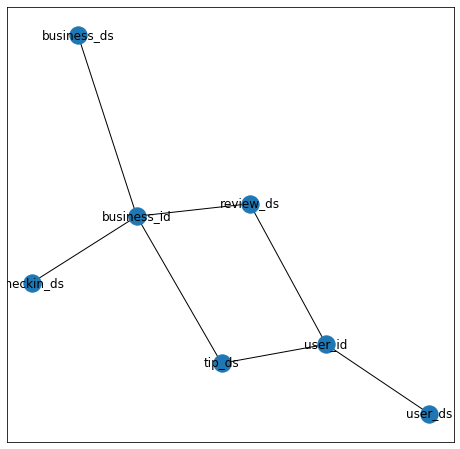

0

In [0]:
# graph to understand the relationship between all datasets
G = nx.Graph()
fig, ax = plt.subplots(figsize=[8,8])
for n, d in zip(dnames, [user_ds, business_ds, checkin_ds, tip_ds, review_ds]):
    _ = []
    for c in np.intersect1d(d.columns, ['business_id', 'user_id']):
        _.append([n, c])
    G.add_edges_from(_, label=n)
nx.draw_networkx(G, ax=ax)
plt.show()
gc.collect()

From the above graph, we see that the business_id is connected to business, checkin, review and tip datasets whereas user_id is connected to user, review and tip datasets. This information is further useful while we generate our recommendation system!


# **Business Data Set**

In [0]:
business_ds.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,None,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."


In [0]:
business_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 14 columns):
business_id     100000 non-null object
name            100000 non-null object
address         100000 non-null object
city            100000 non-null object
state           100000 non-null object
postal_code     100000 non-null object
latitude        100000 non-null float64
longitude       100000 non-null float64
stars           100000 non-null float64
review_count    100000 non-null int64
is_open         100000 non-null int64
attributes      84965 non-null object
categories      99749 non-null object
hours           76700 non-null object
dtypes: float64(3), int64(2), object(9)
memory usage: 11.4+ MB


In [0]:
# Describing Business Dataset
business_ds.describe()

,latitude,longitude,stars,review_count,is_open
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,38.534036,-97.615596,3.588065,33.419970,0.822120
std,4.933993,16.689835,1.018986,113.244013,0.382414
min,33.204863,-115.477519,1.000000,3.000000,0.000000
25%,33.637066,-112.275332,3.000000,4.000000,1.000000
50%,36.144765,-111.764169,3.500000,9.000000,1.000000
75%,43.596350,-79.988363,4.500000,25.000000,1.000000
max,51.299943,-72.911982,5.000000,8348.000000,1.000000


**OBSERVATION**

The minimum and maximum values for is_open is 0 and 1 which suggests that it is a boolean value depicting whether a restaurent is open or not

The minimum and maximum values of stars for the business is in the range of 1-5 where the average rating for a particular business is 3.58

The minimum review_count for a business is 3 with maximum of about 8348 averaging around 33.41

In [0]:
# check for NaN's
business_ds.isna().any()

business_id     False
name            False
address         False
city            False
state           False
postal_code     False
latitude        False
longitude       False
stars           False
review_count    False
is_open         False
attributes       True
categories       True
hours            True
dtype: bool

In [0]:
# drop columns which have all null values
business_ds.dropna(axis=1, how='all')

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,None,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,wWV90q48ugyxyXW6gZav8w,Arepas,521 St. Catherine Street W,Montréal,QC,H3B 1A6,45.504597,-73.568456,3.5,15,0,"{'Alcohol': 'u'none'', 'RestaurantsAttire': 'u...","Restaurants, Venezuelan, Latin American",None
99996,phSaT3I_y6To1J2OdeFSUQ,Ed Mirvish Theatre,244 Victoria Street,Toronto,ON,M5B 1V8,43.655290,-79.379541,4.0,58,1,{'GoodForKids': 'True'},"Arts & Entertainment, Performing Arts",None
99997,oU6Q3ymg1Qsh1EUI6oQwQg,BASIS Ahwatukee,10210 South 50th Pl,Phoenix,AZ,85044,33.354284,-111.975538,2.5,3,1,None,"Education, Middle Schools & High Schools","{'Monday': '7:30-17:30', 'Tuesday': '7:30-17:3..."
99998,gdiOk0n7DmNE9w8xeHWkvw,Brows Redefined,"6670 S Tenaya Way, Ste 120, The Body Spa",Las Vegas,NV,89113,36.066952,-115.251008,5.0,15,1,"{'ByAppointmentOnly': 'True', 'BikeParking': '...","Beauty & Spas, Eyelash Service, Waxing, Esthet...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-19:0', '..."


In [0]:
# Let us check if all business Id's unique
business_ds.business_id.is_unique

True

In [0]:
# Let us count the number of cities where the business is present (Needs fixation)
df = pd.DataFrame(business_ds.city.value_counts())
df

,city
Las Vegas,15244
Toronto,9781
Phoenix,9770
Charlotte,4910
Scottsdale,4685
...,...
Salaberry-De-Valleyfield,1
Newburgh Heights,1
NORTH YORK,1
Mentor-On-The-Lake,1


In [0]:
# Let us look at the top 20 reviewed business
business_ds[['name','business_id', 'review_count', 'city', 'stars']].sort_values(ascending=False, by="review_count")[0:20]


,name,business_id,review_count,city,stars
82250,Mon Ami Gabi,4JNXUYY8wbaaDmk3BPzlWw,8348,Las Vegas,4.0
89206,Bacchanal Buffet,RESDUcs7fIiihp38-d6_6g,8339,Las Vegas,4.0
35199,Wicked Spoon,K7lWdNUhCbcnEvI0NhGewg,6708,Las Vegas,3.5
58852,Hash House A Go Go,f4x1YBxkLrZg652xt2KR5g,5763,Las Vegas,4.0
83950,Earl of Sandwich,DkYS3arLOhA8si5uUEmHOw,5075,Las Vegas,4.5
89437,The Cosmopolitan of Las Vegas,5LNZ67Yw9RD6nf4_UhXOjw,4322,Las Vegas,4.0
29614,Secret Pizza,iCQpiavjjPzJ5_3gPD5Ebg,4286,Las Vegas,4.0
1975,The Buffet at Bellagio,ujHiaprwCQ5ewziu0Vi9rw,4227,Las Vegas,3.5
63010,Bouchon,rcaPajgKOJC2vo_l3xa42A,3859,Las Vegas,4.0
47512,McCarran International Airport,FaHADZARwnY4yvlvpnsfGA,3627,Las Vegas,3.5


In [0]:
# Cities with most reviews and best ratings for their business
city_business_reviews = business_ds[['city', 'review_count', 'stars']].groupby(['city']).\
agg({'review_count': 'sum', 'stars': 'mean'}).sort_values(by='review_count', ascending=False)
city_business_reviews.head(10)

,review_count,stars
city,,
Las Vegas,1015183,3.689025
Phoenix,370619,3.654606
Toronto,261768,3.452714
Scottsdale,198070,3.939168
Charlotte,151622,3.537373
Pittsburgh,112247,3.601552
Henderson,109139,3.776608
Tempe,100737,3.690415
Chandler,81895,3.759349


Text(0.5, 1.0, 'Top 20 cities by reviews')

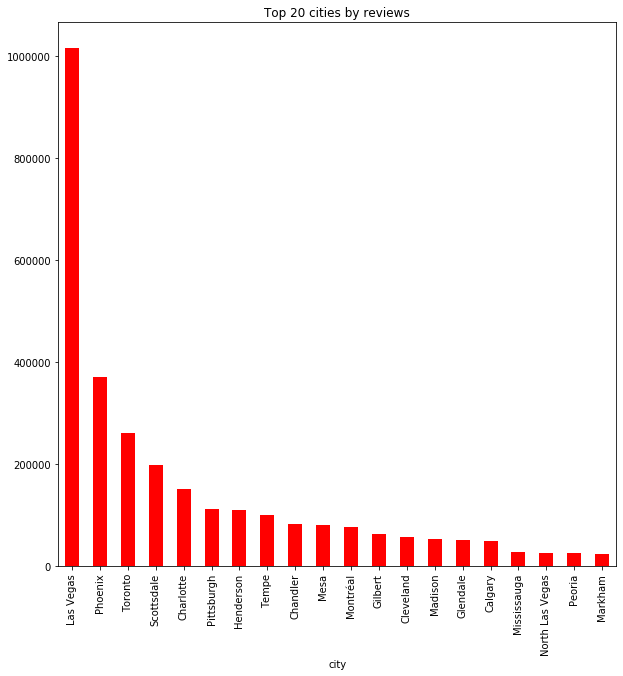

In [0]:
# visualising the top 20 cities in terms of review counts
city_business_reviews['review_count'][0:20].plot(kind='bar', stacked=False, figsize=[10,10], \
                                                 colormap='autumn')
plt.title('Top 20 cities by reviews')

Text(0.5, 1.0, 'Cities with greater than 20k reviews ranked by average stars')

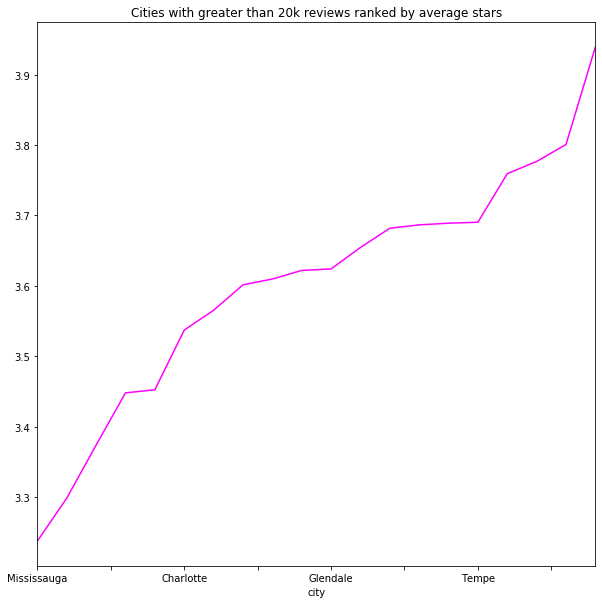

In [0]:
# visualising cities with greater than 20k reviews ranked by stars
city_business_reviews[city_business_reviews.review_count > 20000]['stars'].sort_values()\
.plot(kind='line', figsize=[10,10], colormap='spring')
plt.title('Cities with greater than 20k reviews ranked by average stars')

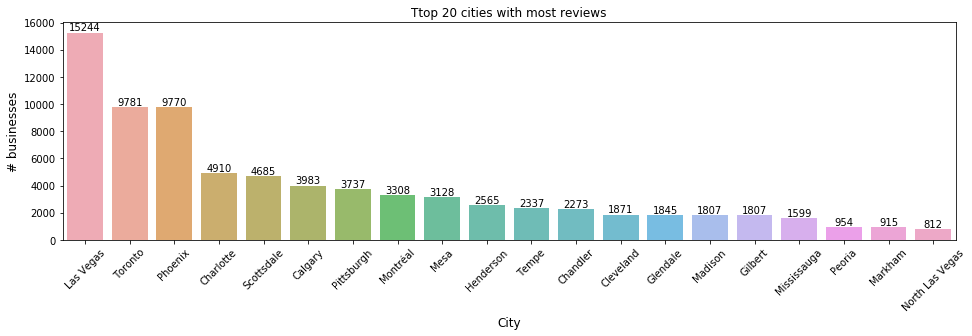

6957

In [0]:
# Get the distribution of the ratings
x=business_ds['city'].value_counts().sort_values(ascending=False)
x=x.iloc[0:20]
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Ttop 20 cities with most reviews")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('City', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()
gc.collect()

95

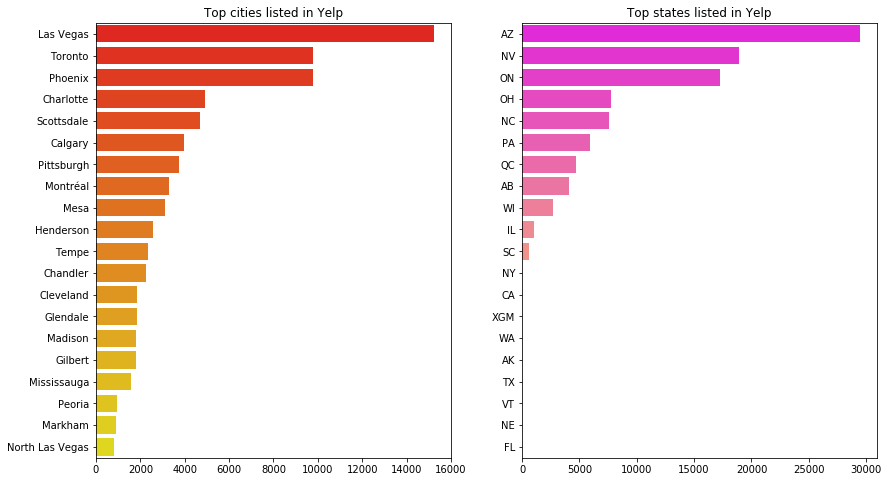

In [0]:
f,ax = plt.subplots(1,2, figsize=(14,8))
ax1,ax2, = ax.flatten()

cnt = business_ds['city'].value_counts()[:20].to_frame()
sns.barplot(cnt['city'], cnt.index, palette = 'autumn', ax =ax1)
ax1.set_xlabel('')
ax1.set_title('Top cities listed in Yelp')

cnt = business_ds['state'].value_counts()[:20].to_frame()
sns.barplot(cnt['state'], cnt.index, palette = 'spring', ax =ax2)
ax2.set_xlabel('')
ax2.set_title('Top states listed in Yelp');
gc.collect()

**OBSERVATION**

City Las Vegas is top list in business listing in Yelp.com

State AZ is top in the list of Yelp.com

There are few states having very few business listing

Text(0.5, 1.0, 'Top name of store in Yelp')

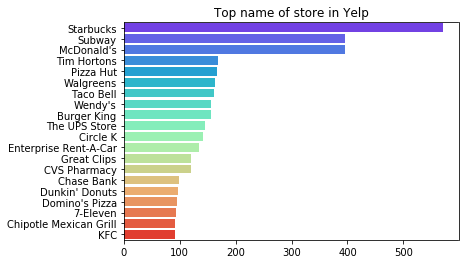

In [0]:
plt.plot(figsize=(20,20))
#ax1 = ax.flatten()

cnt = business_ds['name'].value_counts()[:20].to_frame()
sns.barplot(cnt['name'], cnt.index, palette = 'rainbow')
plt.xlabel('')
plt.title('Top name of store in Yelp')

**OBSERVATION**

'Starbucks' is top in list

'Chase bank' and 'Bank of America' is in top 20

In [0]:
# Distribution of stars in business data
business_ds['stars'].value_counts()

4.0    18656
3.5    18229
5.0    14748
4.5    14175
3.0    13443
2.5     9733
2.0     5868
1.5     2616
1.0     2532
Name: stars, dtype: int64

Text(0.5, 0, 'Star Ratings ')

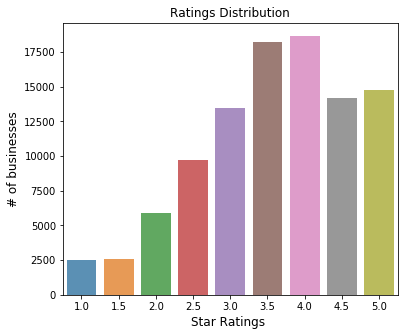

In [0]:
#plotting of stars in busines data
x=business_ds['stars'].value_counts().sort_index()
plt.figure(figsize=(6,5))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Ratings Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

**OBSERVATION**

4 star rating is given by maximum users

1 star rating to businessess are the least

Majority of star rating given to businesses are above 3 stars which signifies that most businesses have got a positive feedback from users

# **Analysis On User Reviews**

In [0]:
review_ds.head(5)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


In [0]:
review_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
business_id    100000 non-null object
cool           100000 non-null int64
date           100000 non-null datetime64[ns]
funny          100000 non-null int64
review_id      100000 non-null object
stars          100000 non-null int64
text           100000 non-null object
useful         100000 non-null int64
user_id        100000 non-null object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 7.6+ MB


In [0]:
review_ds.describe()

,cool,funny,stars,useful
count,100000.00000,100000.000000,100000.000000,100000.000000
mean,0.54412,0.442580,3.736920,1.279980
std,2.04579,1.648487,1.454589,2.919489
min,0.00000,0.000000,1.000000,0.000000
25%,0.00000,0.000000,3.000000,0.000000
50%,0.00000,0.000000,4.000000,0.000000
75%,0.00000,0.000000,5.000000,1.000000
max,94.00000,74.000000,5.000000,101.000000


In [0]:
#Check null value
review_ds.isnull().sum()

business_id    0
cool           0
date           0
funny          0
review_id      0
stars          0
text           0
useful         0
user_id        0
dtype: int64

Text(0, 0.5, '')

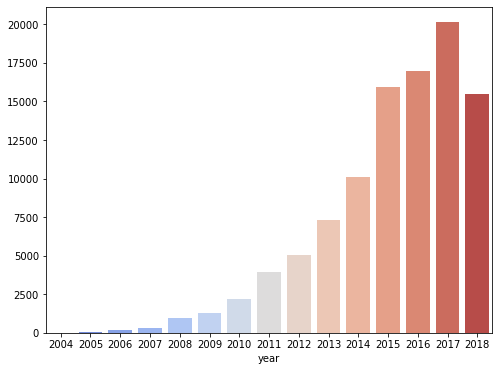

In [0]:
# Review distribution according to the year and month
review_ds['year'] = review_ds['date'].dt.year

plt.figure(figsize = (8,6))
cnt = review_ds.groupby('year').count()['stars'].to_frame()
sns.barplot(cnt.index, cnt['stars'],palette = 'coolwarm')
plt.ylabel('')

**OBSERVATION**

Number of user providing reviews on yelp are increasing every year and maximum reviews are in 2017

# **Analysis On User Dataset**

In [0]:
user_ds.head(5)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,95,2013-10-08 23:11:33,84,17,25,"2015,2016,2017","c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz5g...",5,4.03,2,0,0,0,0,1,1,1,1,2,0
1,4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,3.63,1,0,0,0,0,0,0,1,1,0,0
2,bc8C_eETBWL0olvFSJJd0w,David,16,2013-10-04 00:16:10,28,8,10,,"4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng...",0,3.71,0,0,0,0,0,1,0,0,0,0,0
3,dD0gZpBctWGdWo9WlGuhlA,Angela,17,2014-05-22 15:57:30,30,4,14,,"RZ6wS38wnlXyj-OOdTzBxA, l5jxZh1KsgI8rMunm-GN6A...",5,4.85,1,0,0,0,0,0,2,0,0,1,0
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,361,2013-10-23 07:02:50,1114,279,665,"2015,2016,2017,2018","mbwrZ-RS76V1HoJ0bF_Geg, g64lOV39xSLRZO0aQQ6DeQ...",39,4.08,28,1,0,0,1,16,57,80,80,25,5


In [0]:
user_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 22 columns):
user_id               100000 non-null object
name                  100000 non-null object
review_count          100000 non-null int64
yelping_since         100000 non-null object
useful                100000 non-null int64
funny                 100000 non-null int64
cool                  100000 non-null int64
elite                 100000 non-null object
friends               100000 non-null object
fans                  100000 non-null int64
average_stars         100000 non-null float64
compliment_hot        100000 non-null int64
compliment_more       100000 non-null int64
compliment_profile    100000 non-null int64
compliment_cute       100000 non-null int64
compliment_list       100000 non-null int64
compliment_note       100000 non-null int64
compliment_plain      100000 non-null int64
compliment_cool       100000 non-null int64
compliment_funny      100000 non-null int64
com

In [0]:
user_ds.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,82.558470,211.546330,104.439670,133.010090,7.146770,3.798690,13.757830,1.73952,1.254500,1.005030,0.477890,8.135450,18.552510,18.771650,18.771650,7.094370,7.262320
std,201.292528,1353.683818,941.570493,1149.299821,38.507842,0.733975,216.503309,21.10247,27.541587,16.835325,10.529963,78.640364,215.653474,214.506727,214.506727,80.523743,188.018509
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,6.000000,1.000000,1.000000,0.000000,3.450000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24.000000,23.000000,5.000000,6.000000,1.000000,3.860000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,71.000000,85.000000,23.000000,27.000000,3.000000,4.250000,1.000000,0.00000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000
max,12390.000000,89792.000000,86122.000000,83915.000000,2964.000000,5.000000,34167.000000,3575.00000,5660.000000,2254.000000,2261.000000,7579.000000,14888.000000,19348.000000,19348.000000,8341.000000,39055.000000


**OBSERVATION**

Minimum average_stars rating for a user is 1, maximum value of rating is 5 and minimum is 0

The average of the average_star rating for a user is 3.79

In [0]:
# The 10 most popular user
user_ds.sort_values('fans', ascending=False).head(10)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
1301,hizGc5W1tBHPghM5YKCAtg,Katie,1448,2009-05-22 20:19:55,37796,26881,31252,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2018","BsPTBl0_5rZXrfVP4HffqQ, _NNnlcRTDIYqejVEAZ5Fmw...",2964,4.19,6313,408,401,366,252,2881,14888,7268,7268,2446,1447
1271,eKUGKQRE-Ywi5dY55_zChg,Cherylynn,2190,2008-01-20 06:27:03,78888,64172,65573,"2010,2011,2012,2013,2014,2015,2016,2017,2018","9meGsHGlIwf-W8VIh7-DVA, DHs8No90RxNP6EQHHNEZvg...",2434,3.67,21956,1981,2510,1195,397,7579,12650,19348,19348,8341,39055
1239,ITa3vh5ERI90G_WP4SmGUQ,Peter,2939,2008-05-06 01:30:13,41172,45625,31778,"2008,2009,2010,2011,2012,2013,2014,2015,2016,2...","itEBF-wdxhHapBxT35XoMA, DYqujEDnSMgwL7sFTRSv8w...",2086,3.98,2317,362,335,338,340,2384,8654,4325,4325,1539,579
10806,m07sy7eLtOjVdZ8oN9JKag,Ed,4400,2006-07-22 01:22:26,51201,39114,44201,"2006,2007,2008,2009,2010,2011,2012,2013,2014,2...","weI3gUj0DiKXkp8seBYKfw, iQCOko4X7KQrmHdLiV1o9A...",1780,3.66,2516,319,163,150,208,745,1175,2743,2743,2351,2158
4502,fgwI3rYHOv1ipfVfCSx7pg,Emi,1690,2009-09-17 09:11:14,37334,28125,32565,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2018","rGJQwYZNcmRrYQWlvhBBZQ, NgX6wFfGP8i8QZZwIZhZbw...",1698,4.29,3754,190,167,222,87,1606,9173,5505,5505,1255,1269
7023,Hi10sGSZNxQH3NLyWSZ1oA,Fox,6407,2009-05-26 11:33:58,89418,86122,82128,"2014,2015,2016,2017,2018","2vFUeQGnG8zdLSQkwfChog, 6YDC4RNaAUdTSkhJ1WUC9w...",1574,3.83,3032,361,337,111,40,1861,4379,5429,5429,1371,2276
538,G9Vb6yQ047TC3O_-GG4WZA,Connie,1540,2005-10-05 21:46:41,24513,15949,22616,"2006,2007,2008,2009,2010","wvo6CDYUY6gD6q_iLjmAOQ, cvp_9tPerFLdvSKlTnXKTQ...",1558,4.17,6849,217,230,1339,124,1135,4263,4527,4527,946,855
256,WG3w_73scm_JUWJ_3Lgn0Q,Jack,4534,2011-06-29 22:41:05,58513,27141,47149,"2012,2013,2014,2015,2016,2017,2018","68XxoMUi-DFklQEWQlpMww, Dsb1QrODMkX-cU7vUhdCBg...",1500,3.85,1437,275,72,59,64,1675,5371,3455,3455,1504,1963
4587,ysCBsXWPB-LAiewVS3jZfQ,Jando,3517,2006-11-08 07:31:36,22159,11031,15866,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...","hozuvS9opaptx-oVT3wDWg, NT5PIrm_5PMIvhKThayOIg...",1462,3.47,2912,336,354,127,222,3119,12022,5729,5729,1285,489
867,djxnI8Ux8ZYQJhiOQkrRhA,Abby,2158,2008-05-09 13:48:14,24367,13152,18359,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2018","Lu8y2ayxVlAzuJEVfVcH4w, wxX0rBrvY71iaDrvS_sMfQ...",1443,4.12,2549,225,209,259,102,1995,8962,3591,3591,911,535


In [0]:
# All user_id's are unique or not
user_ds['user_id'].is_unique

True

# **Tip/ Feedback Analysis**

In [0]:
tip_ds.head(5)

,user_id,business_id,text,date,compliment_count
0,UPw5DWs_b-e2JRBS-t37Ag,VaKXUpmWTTWDKbpJ3aQdMw,"Great for watching games, ufc, and whatever el...",2014-03-27 03:51:24,0
1,Ocha4kZBHb4JK0lOWvE0sg,OPiPeoJiv92rENwbq76orA,Happy Hour 2-4 daily with 1/2 price drinks and...,2013-05-25 06:00:56,0
2,jRyO2V1pA4CdVVqCIOPc1Q,5KheTjYPu1HcQzQFtm4_vw,Good chips and salsa. Loud at times. Good serv...,2011-12-26 01:46:17,0
3,FuTJWFYm4UKqewaosss1KA,TkoyGi8J7YFjA6SbaRzrxg,The setting and decoration here is amazing. Co...,2014-03-23 21:32:49,0
4,LUlKtaM3nXd-E4N4uOk_fQ,AkL6Ous6A1atZejfZXn1Bg,Molly is definately taking a picture with Sant...,2012-10-06 00:19:27,0


In [0]:
tip_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 5 columns):
user_id             100000 non-null object
business_id         100000 non-null object
text                100000 non-null object
date                100000 non-null datetime64[ns]
compliment_count    100000 non-null int64
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 4.6+ MB


In [0]:
tip_ds.describe()

,compliment_count
count,100000.000000
mean,0.020250
std,0.160438
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,6.000000


# **Conclusion**

In this jupyter notebook, we explored and analyzed the Yelp Dataset. Now we will predict the ratings of the user based on the review. After that we will recommend restaurants based on collaborative filtering and content.




# **MIT License**

Copyright (c) 2019 Rashika Moza, Abhi Patodi, Soumya Pandey

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE

